In [2]:
import pandas as pd
import joblib
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import shap
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

/home/sakamoto/miniforge3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
def cal_df_feature(df):
    df_feature = pd.DataFrame(df.drop(['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz'], axis=1).columns).reset_index().rename(columns = {'index':'id',0:'feature'})

    def replace_values(x):
        if isinstance(x, str) and ('MCHvalue' in x):
            return x
        else:
            num_x = int(x)
            if num_x <= 0:
                return f"NL: {-num_x}"
            else:
                return f"m/z: {num_x}"

    df_feature['featurename'] = df_feature['feature'].apply(replace_values)
    df_feature['id'] = df_feature['id'].apply(lambda x: 'Feature ' + str(x))

    return df_feature


def cal_mean_value(df, select_ont, number_to_class_pos):
    df2 = pd.DataFrame(df).rename(columns=number_to_class_pos)[select_ont]
    return df2

def italicize_mz(column_name):
    if 'm/z' in column_name:
        # 'm/z'部分だけを斜体にする
        parts = column_name.split('m/z')
        return f"{parts[0]}$\\it{{m/z}}${parts[1]}"
    else:
        return column_name

def cal_mean_shapdf(shap_values_pos, df_pos2x, path, custom_legend_order, number_to_class_pos):
    mean_shap_values = np.mean([np.abs(sv) for sv in shap_values_pos], axis=0)

    mean_shap_values2 = cal_mean_value(mean_shap_values, custom_legend_order, number_to_class_pos)
    df_feature = cal_df_feature(df_pos2x)
    df_feature.to_csv(path, index=False)
    feature_names = df_feature['featurename']

    # top20
    df_top_features = pd.DataFrame(mean_shap_values2.sum(axis=1)).rename(columns={0:'sumvalue'}).\
        sort_values("sumvalue", ascending=False)[:20].reset_index()
    top_feature_names = feature_names.iloc[df_top_features['index']]
    df_feature_top20_pos = mean_shap_values2.T[df_top_features['index']]
    df_feature_top20_pos.columns = top_feature_names
    df_feature_top20_pos = df_feature_top20_pos.loc[custom_legend_order]

    return df_feature_top20_pos

pos

In [12]:
df_pos2x = pd.read_csv('../../data/basedata/df_pos_MCH.csv')
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_pos2x.drop(columns=columns_to_drop).astype(float).values
y = df_pos2x['Ontology']
X_train_pos, X_test_pos, y_train_pos, y_test_pos = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

loaded_model_pos = joblib.load('../../data/model_comp/pos_pred_result/best_xgb_model_random_pos.joblib')
label_encoder_pos = joblib.load('../../data/model_comp/pos_pred_result/label_encoder_pos_random.pkl')
number_to_class_pos = {index: label for index, label in enumerate(label_encoder_pos.classes_)}
y_train_pos = label_encoder_pos.transform(y_train_pos)
y_test_pos = label_encoder_pos.transform(y_test_pos)

In [13]:
explainer_pos = shap.TreeExplainer(loaded_model_pos)
shap_values_pos = explainer_pos.shap_values(X_test_pos)

np.save('../../data/model_comp/shap/pos/pos_shapvalues.npy', shap_values_pos)
shap_values_pos = np.load('../../data/model_comp/shap/pos/pos_shapvalues.npy')

neg

In [14]:
df_neg2x = pd.read_csv('../../data/basedata/df_neg_MCH.csv')
columns_to_drop = ['Metabolitename', 'Ontology', 'dataset', 'AlignmentID', 'AverageMz']
X = df_neg2x.drop(columns=columns_to_drop).astype(float).values
y = df_neg2x['Ontology']
X_train_neg, X_test_neg, y_train_neg, y_test_neg = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

loaded_model_neg = joblib.load('../../data/model_comp/neg_pred_result/best_xgb_model_random_neg.joblib')
label_encoder_neg = joblib.load('../../data/model_comp/neg_pred_result/label_encoder_neg_random.pkl')
number_to_class_neg = {index: label for index, label in enumerate(label_encoder_neg.classes_)}
y_train_neg = label_encoder_neg.transform(y_train_neg)
y_test_neg = label_encoder_neg.transform(y_test_neg)

In [15]:
explainer_neg = shap.TreeExplainer(loaded_model_neg)
shap_values_neg = explainer_neg.shap_values(X_test_neg)

np.save('../../data/model_comp/shap/neg/neg_shapvalues.npy', shap_values_neg)
shap_values_neg = np.load('../../data/model_comp/shap/neg/neg_shapvalues.npy')

plot

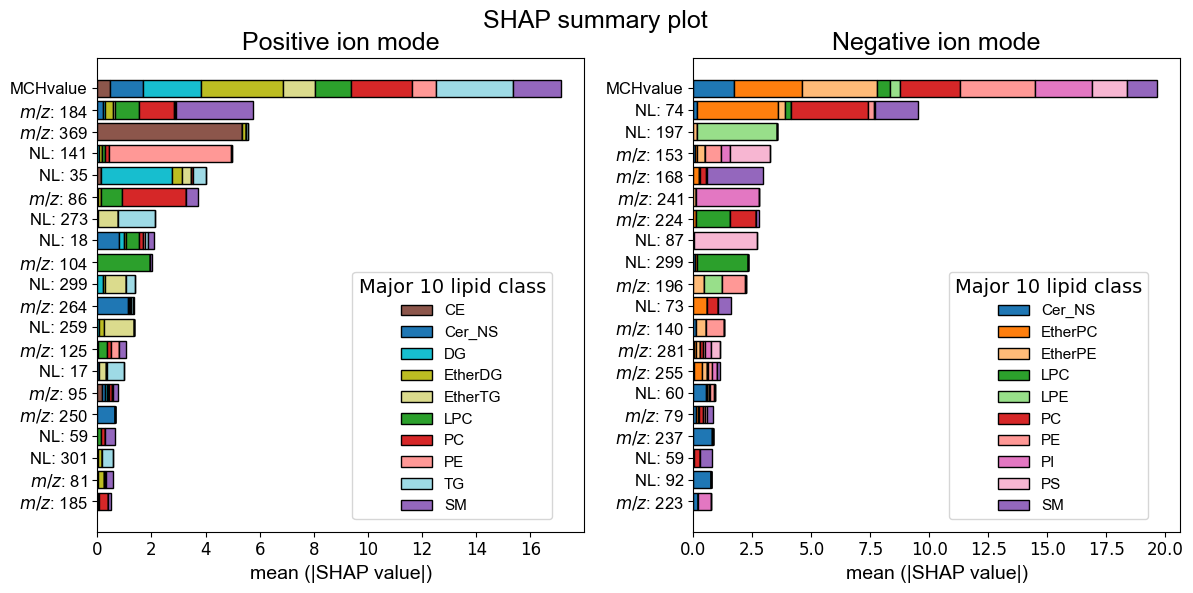

In [16]:
arial_path = '../../arial.ttf'
arial = fm.FontProperties(fname=arial_path, size=11)

custom_legend_order_pos = ['CE', 'Cer_NS', 'DG','EtherDG', 'EtherTG', 'LPC',  'PC', 'PE', 'TG', 'SM']
df_feature_top20_pos = cal_mean_shapdf(shap_values_pos, df_pos2x, '../../data/model_comp/pos_pred_result/df_feature_pos.csv', custom_legend_order_pos, number_to_class_pos)
columns_names_pos = [italicize_mz(col) for col in df_feature_top20_pos.columns]

custom_legend_order_neg =   ['Cer_NS', 'EtherPC', 'EtherPE', 'LPC','LPE', 'PC', 'PE', 'PI', 'PS', 'SM'] 
df_feature_top20_neg = cal_mean_shapdf(shap_values_neg, df_neg2x, '../../data/model_comp/neg_pred_result/df_feature_neg.csv', custom_legend_order_neg, number_to_class_neg)
columns_names_neg = [italicize_mz(col) for col in df_feature_top20_neg.columns]

cl = plt.cm.tab20.colors
cmap_POS = [cl[10], cl[0], cl[18], cl[16], cl[17], cl[4],  cl[6], cl[7], cl[19], cl[8]]
cmap_NEG = [cl[0], cl[2], cl[3], cl[4], cl[5], cl[6], cl[7], cl[12], cl[13], cl[8]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# positive
bars_pos = []
for i in range(len(df_feature_top20_pos)):
    bars = ax1.barh(df_feature_top20_pos.columns, df_feature_top20_pos.iloc[i], left=df_feature_top20_pos.iloc[:i].sum(), color=cmap_POS[i], edgecolor='black', linewidth=1)
    bars_pos.append(bars)
ax1.set_title('Positive ion mode', fontproperties=arial, fontsize=18)
ax1.set_xlabel('mean (|SHAP value|)', fontproperties=arial, fontsize=14)
ax1.set_ylabel('')
ax1.tick_params(labelsize=12)
ax1.set_yticks(range(len(columns_names_pos)))
ax1.set_yticklabels(columns_names_pos, fontproperties=arial, fontsize=12)
ax1.invert_yaxis()

# negative
bars_neg = []
for i in range(len(df_feature_top20_neg)):
    bars = ax2.barh(df_feature_top20_neg.columns, df_feature_top20_neg.iloc[i], left=df_feature_top20_neg.iloc[:i].sum(), color=cmap_NEG[i], edgecolor='black', linewidth=1)
    bars_neg.append(bars)
ax2.set_title('Negative ion mode', fontproperties=arial, fontsize=18)
ax2.set_xlabel('mean (|SHAP value|)', fontproperties=arial, fontsize=14)
ax2.set_ylabel('')
ax2.tick_params(labelsize=12)
ax2.set_yticks(range(len(columns_names_neg)))
ax2.set_yticklabels(columns_names_neg, fontproperties=arial, fontsize=12)
ax2.invert_yaxis()

ax1.legend(bars_pos, custom_legend_order_pos, title='Major 10 lipid class', prop=arial, fontsize=14, title_fontsize=14, bbox_to_anchor=(0.95, 0.01), loc='lower right')
ax2.legend(bars_neg, custom_legend_order_neg, title='Major 10 lipid class', prop=arial, fontsize=14, title_fontsize=14,bbox_to_anchor=(0.95, 0.01), loc='lower right')

plt.tight_layout()
plt.suptitle('SHAP summary plot', fontproperties=arial, fontsize=18)
plt.subplots_adjust(top=0.9)
plt.savefig('../../data/model_comp/shap/shap_plots.svg', format='svg', dpi=300, bbox_inches='tight')